# Solving incompressible heat flow in a cavity

Let us consider the Navier-Stokes equations for the velocity $\mathbf{u}$ and the pressure $p$ of an incompressible fluid

\begin{align*} 
    \nabla \cdot \mathbf{u} &= 0,  \\
    \mathbf{u}_t + \left( \mathbf{u}\cdot\nabla \right)\mathbf{u} + \nabla p - 2\mu \nabla \cdot \mathbf{D}(\mathbf{u}) &= 0,
\end{align*}


where  $\mathbf{D}(\mathbf{u}) = \mathrm{sym}(\mathbf{u}) = \frac{1}{2}\left(\nabla \mathbf{u} +  \left( \nabla \mathbf{u} \right)^{\mathrm{T}} \right)$ is the Newtonian fluid's rate of strain tensor and $\mu$ is the viscosity.
Moreover, consider a convection-diffusion equation that governs the evolution of the temperature field

\begin{align*} 
    T_t + \mathbf{u}\cdot\nabla T - \kappa \Delta T &= 0,
\end{align*}

where $\kappa$ is the constant thermal condictivity. 

## Python packages

Import the Python packages for use in this notebook.

We need the finite element method library FEniCS.

In [1]:
import fenics

In [2]:
#import mshr 

In [3]:
import dolfin
dolfin.__version__

'2019.2.0.dev0'

In [4]:
import ufl
ufl.__version__

'2019.2.0.dev0'

In [5]:
import pymor
pymor.__version__

'2020.2.2'

FEniCS has convenient plotting features that don't require us to import `matplotlib`; but using `matplotlib` directly will allow us to annotate the plots.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Benchmark parameters

Set constant Reynolds number and Prandtl number. For each we define a `fenics.Constant` for use in the variational form so that FEniCS can more efficiently compile the finite element code.

In [7]:
dynamic_viscosity = 10.
Re = fenics.Constant(500)
#mu = fenics.Constant(dynamic_viscosity)
prandtl_number = 0.71
Pr = fenics.Constant(prandtl_number)
kappa = fenics.Constant(1./prandtl_number)

Furthermore the benchmark problem involves hot and cold walls with constant temperatures $T_h$ and $T_c$, respectively, and the initial temperature $T_i$ of the domain.

In [8]:
hot_wall_temperature = 0.5
T_h = fenics.Constant(hot_wall_temperature)
cold_wall_temperature = -0.5
T_c = fenics.Constant(cold_wall_temperature)
initial_temperature = 0.0
T_i = fenics.Constant(cold_wall_temperature)

## Structured mesh definition
Now, define a structured mesh on the rectangle with bottom left point $(0,0)$ and top right point $(\bar{x},\bar{y}) = (\bar{x},1)$ and ratio $(\bar{y} - 0)/(\bar{x} - 0) = 1/\bar{x}$.

In [9]:
ratio = 1.0/1.2

In [10]:
if 0:
    N = 8
    mesh = fenics.UnitSquareMesh(N, N)
    ratio = 1.0
elif 1:
    ny = 10
    nx = int(ny*1.0/ratio)
    mesh = fenics.RectangleMesh(fenics.Point(0, 0), fenics.Point(1.0/ratio,1.0), nx, ny, "right/left")
else: 
    #unstructured mesh
    domain = mshr.Rectangle(fenics.Point(0, 0), fenics.Point(1.0/ratio,1.0))
    mesh = mshr.generate_mesh(domain, 8)

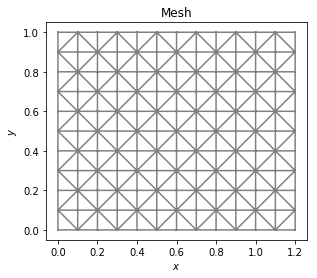

In [11]:
fenics.plot(mesh)
plt.title("Mesh")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

## Mixed finite element function space, test functions, and solution functions

Make the mixed finite element. We choose pressure and velocity subspaces analagous to the Taylor-Hood (i.e. P2P1) mixed element [1], but we extend this further with a P1 element for the temperature.

In [12]:
P1 = fenics.FiniteElement('P', mesh.ufl_cell(), 1)
P2 = fenics.VectorElement('P', mesh.ufl_cell(), 2)

#P2 = fenics.VectorFunctionSpace(mesh, 'P', 2)
#P1 = fenics.FunctionSpace(mesh, 'P', 1)

mixed_element = fenics.MixedElement([P1, P2,P1])

|Note|
|----|
|`fenics.FiniteElement` requires the `mesh.ufl_cell()` argument to determine some aspects of the domain (e.g. that the spatial domain is two-dimensional).|

Make the mixed finite element function space $\mathbf{W}$, which enumerates the mixed element basis functions for pressure and velocity on each cell of the mesh.

In [13]:
W = fenics.FunctionSpace(mesh, mixed_element)

Make the P1 finite element function space $\mathbf{W}_T$ for the temperature field.

In [14]:
#W_T = fenics.FunctionSpace(mesh, P1)

Make the test functions $\psi_p,\boldsymbol{\psi}_u \in \mathbf{W}$, and $\psi_T \in \mathbf{W}_T$.

In [15]:
# TestFunctions
psi_p, psi_u, psi_T = fenics.TestFunctions(W)

In [16]:
type(psi_p), type(psi_u), type(psi_T)

(ufl.indexed.Indexed, ufl.tensors.ListTensor, ufl.indexed.Indexed)

Make the Navier-Stokes system solution function $\mathbf{w} \in \mathbf{W}$ and obtain references to its components $p$, $\mathbf{u}$, and define the temperature solution function $T \in \mathbf{W}_T$.

In [17]:
w = fenics.Function(W)
p, u, T = fenics.split(w)

#test functions
w_n = fenics.Function(W)
p_n, u_n, T_n = fenics.split(w_n)

### Time discretization

We are solving an initial value problem. We will prescribe the initial values, and then take discrete steps forward in time which solve the governing equations. For this we consider the initial values

\begin{align*}
    p^0  = 0,  \\
    \mathbf{u}^0 = \begin{pmatrix} 0 \\ 0 \end{pmatrix}, \\
\end{align*}
and
\begin{align*}
    T^0  = T_h + x_0(T_c - T_h)\quad \text{ or } \quad T^0 = T_i.
\end{align*}

Interpolate these values to create the initial solution function.

w_n = fenics.interpolate(fenics.Expression(("0.", "0.", "0.","T_i" ), 
                         T_i = initial_temperature,element = mixed_element),W)

p_n, u_n, T_n = fenics.split(w_n)

if 0:
    T_n = fenics.interpolate(
        fenics.Expression(("T_h + x[0]*(T_c - T_h)"), 
                          T_h = hot_wall_temperature, T_c = cold_wall_temperature,
                          element = P1), W_T)
elif 0:
    T_n = fenics.interpolate(
        fenics.Expression(("T_i"), 
                          T_i = initial_temperature,
                          element = P1), W_T)    
#endif

Let's look at the initial temperature field.

Text(0, 0.5, '$y$')

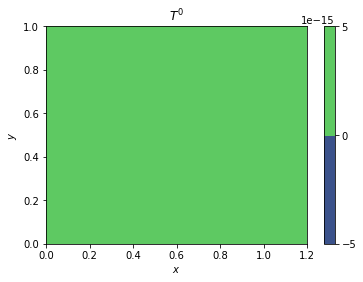

In [18]:
fig = fenics.plot(T_n)
plt.colorbar(fig)
plt.title("$T^0$")
plt.xlabel("$x$")
plt.ylabel("$y$")

For the time derivative terms $\mathbf{u}_t$ and $T_t$, we apply the first-order implicit Euler finite difference time discretization, i.e.

\begin{align*}
    \mathbf{u}_t = \frac{\mathbf{u}^{n+1} - \mathbf{u}^n}{\Delta t} \\
    T_t = \frac{T^{n+1} - T^n}{\Delta t}
\end{align*}

And we get a fully coupled (monolithic) system at each time step

\begin{align*} 
    \nabla \cdot \mathbf{u}^{n+1} &= 0  \\
    \frac{1}{\Delta t} \mathbf{u}^{n+1}  + \left( \mathbf{u}^{n+1}\cdot\nabla \right)\mathbf{u}^{n+1} + \nabla p - \mu \Delta \mathbf{u}^{n+1} &= \frac{1}{\Delta t} \mathbf{u}^n  \\
    \frac{1}{\Delta t}T^{n+1}  + \mathbf{u}^{n+1}\cdot\nabla T^{n+1} - \kappa \Delta T^{n+1} &= \frac{1}{\Delta t}T^{n}
\end{align*}

|Note|
|----|
|For our implementation, we will use the shorthand $\mathbf{w} = \mathbf{w}^{n+1}= \begin{pmatrix} p^{n+1} \\ \mathbf{u}^{n+1}\end{pmatrix}$, and $T = T^{n+1}$ |

Choose a time step size $\Delta t$and set the time derivative terms.

In [19]:
timestep_size = 0.001
Delta_t = fenics.Constant(timestep_size)
u_t = (u - u_n)/Delta_t
T_t = (T - T_n)/Delta_t

## Nonlinear variational form

Multiply by suitable test funcions $\psi_p, \boldsymbol{\psi}_u, \psi_T$ and integrate over the domain. We obtain

\begin{align*} 
    ({\psi}_p, \nabla \cdot \mathbf{u}) &= 0  \\
    \frac{1}{\Delta t}(\boldsymbol{\psi}_u, \mathbf{u}^{n+1}) + \left( \boldsymbol{\psi}_u,  ( \mathbf{u}\cdot\nabla) \mathbf{u} \right) -(p, \nabla \cdot \boldsymbol{\psi}_u) + \mu (\nabla \mathbf{u}, \nabla \boldsymbol{\psi}_u) -  \frac{1}{\Delta t}(\boldsymbol{\psi}_u, \mathbf{u}^{n}) &=0,
\end{align*}
where
\begin{align*}
b( \mathbf{u},\mathbf{v},\boldsymbol{\psi}_u) &= \left( ( \mathbf{u}\cdot\nabla) \mathbf{v}, \boldsymbol{\psi}_u \right),
\end{align*}
and 
\begin{align*} 
   \frac{1}{\Delta t} ({\psi}_T ,{T^{n+1}})  - (\mathbf{u}^{n+1}\cdot\nabla \psi_T, T^{n+1}) + \kappa(\nabla T^{n+1}, \nabla \psi_T) - \frac{1}{\Delta t} ({\psi}_T ,{T^{n}}) &= 0.
\end{align*}

We can write the nonlinear system of equations as

\begin{align*}
\mathbf{F}(\mathbf{w}) &= \mathbf{0}, \\
\mathbf{G}(\mathbf{T}) &= \mathbf{0}.
\end{align*}


In [20]:
inner, dot, grad, div, sym = \
    fenics.inner, fenics.dot, fenics.grad, fenics.div, fenics.sym
    
mass = -psi_p*div(u)

momentum = dot(psi_u, dot(grad(u), u)) - div(psi_u)*p \
    + 2.*(1./Re)*inner(sym(grad(psi_u)), sym(grad(u)))

energy = dot(grad(psi_T), kappa*grad(T) - T*u)

#G = energy*fenics.dx    
F = (mass + momentum + energy )*fenics.dx

## Boundary conditions

We need boundary conditions before we can define a nonlinear variational *problem* (i.e. in this case a boundary value problem).
For the velocity, we consider the moving top lid 
\begin{align*}
    \mathbf{u}(1,x) &= 
    \begin{pmatrix} 1 \\ 0 \end{pmatrix}, 0 \leq x \leq \bar{x}.
\end{align*}
We physically consider *no slip* velocity boundary conditions for the orther boundaries. These manifest as homogeneous Dirichlet boundary conditions. For the temperature boundary conditions, we consider a constant hot temperature on the left wall, a constant cold temperature on the right wall, and adiabatic (i.e. zero heat transfer) conditions on the top and bottom walls. Because the problem's geometry is simple, we can identify the boundaries with the following piece-wise function.

\begin{align*}
    T(\mathbf{x}) &= 
    \begin{cases}
        T_h , && x_0 = 0, \\
        T_c , && x_0 = \bar{x}.
    \end{cases}
\end{align*}

In [21]:
hot_wall = "near(x[0],  0.)" #x=0 

cold_wall = "near(x[0],"+str(1.0/ratio)+")" #x= \bar{x}

top_wall = "near(x[1],  1.)" #y=1

bottom_wall = "near(x[1],  0.)" #y=0

walls = hot_wall + " | " + cold_wall + " | " + bottom_wall

Define the boundary conditions on the appropriate subspaces.

In [22]:
# numbering starts at 0 -> W.sub(0) = W_p
W_u = W.sub(1)
# set velocity BC
boundary_conditions = [fenics.DirichletBC(W_u, (0., 0.), walls), 
                       fenics.DirichletBC(W_u, (1., 0.), top_wall)]

In [23]:
# set temperature BC
if 1:
    W_T = W.sub(2)
    # set velocity BC
    boundary_conditions.extend([fenics.DirichletBC(W_T, hot_wall_temperature, hot_wall), 
                             fenics.DirichletBC(W_T, cold_wall_temperature, cold_wall)])
elif 0:
    boundary_conditions_T = [fenics.DirichletBC(W_T, hot_wall_temperature, hot_wall),
                             fenics.DirichletBC(W_T, cold_wall_temperature, cold_wall)]
else:
    boundary_conditions_T = [fenics.DirichletBC(W_T, hot_wall_temperature, hot_wall),
                             fenics.DirichletBC(W_T, cold_wall_temperature, bottom_wall)]
#endif

In [24]:
boundary_conditions

## Nonlinear variational problem

Now we have everything we need to solve the variational problem.

In [25]:
# solve the system for velocity and pressure
fenics.solve(F == 0, w, boundary_conditions)

In [26]:
dir(F)
F.coefficients()

(Coefficient(FunctionSpace(None, FiniteElement('Real', None, 0)), 0),
 Coefficient(FunctionSpace(None, FiniteElement('Real', None, 0)), 2),
 Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 6), MixedElement(FiniteElement('Lagrange', triangle, 1), VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', triangle, 1))), 11))

|Note|
|----|
|`solver.solve` will modify the solution `w`, which means that `u` and `p` will also be modified.|

Now plot the velocity field, and pressure and temperature.

In [27]:
def plot_w(w, split = False):
    
    if split:
        p, u, T = fenics.split(w.leaf_node())
    else:
        p, u, T  = w.split()   
    
    fig = fenics.plot(u)
    plt.title("Velocity vector field")
    plt.xlabel("$x$")
    plt.ylabel("$y$")    
    plt.colorbar(fig)  
    plt.show()

    
    fig = fenics.plot(p)
    plt.title("Pressure field")
    plt.xlabel("$x$")
    plt.ylabel("$y$")    
    plt.colorbar(fig)    
    plt.show()
    
    fig = fenics.plot(T)
    plt.title("Temperature field")
    plt.xlabel("$x$")
    plt.ylabel("$y$")    
    plt.colorbar(fig)    
    plt.show()
    
    return

In [34]:
def solve_fom_fenics(mu=1.):
    Re.assign(mu)
    fenics.solve(F == 0, w, boundary_conditions)
    return w

In [82]:
w = solve_fom_fenics(mu=5.)

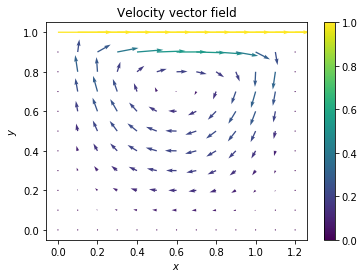

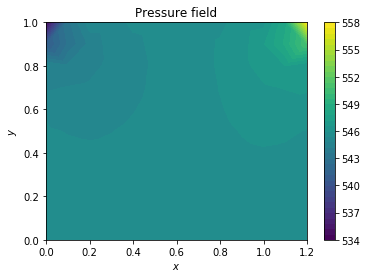

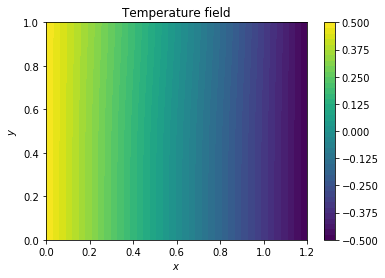

In [83]:
plot_w(w)

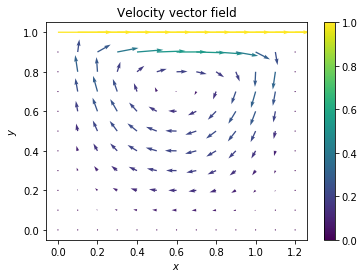

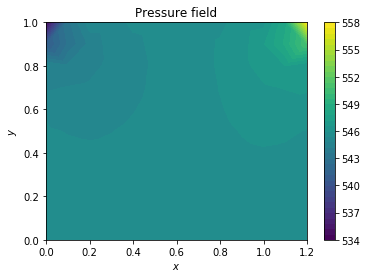

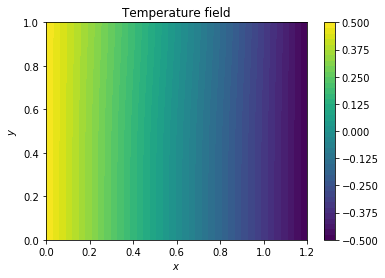

In [84]:
w_l = fenics.Function(W)
w = solve_fom_fenics(mu=5.)
w_l.leaf_node().vector()[:] = w.leaf_node().vector()[:]
plot_w(w_l)

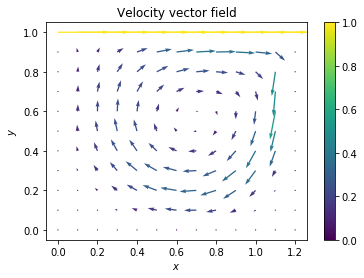

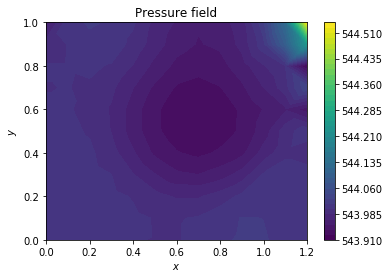

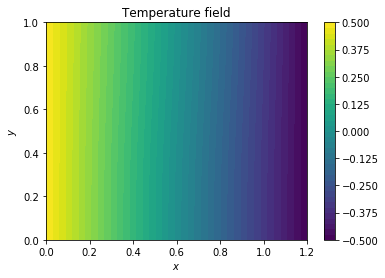

In [85]:
w_h = fenics.Function(W)
w = solve_fom_fenics(mu=500.)
w_h.leaf_node().vector()[:] = w.leaf_node().vector()[:]
plot_w(w_h)

## References

[1] J Donea and A Huerta. **Finite element methods for flow problems.** *John Wiley & Sons*, 2003. 


|Note|
|----|
| This Jupyter notebook server is using FEniCS '2019.2.0.dev0' |

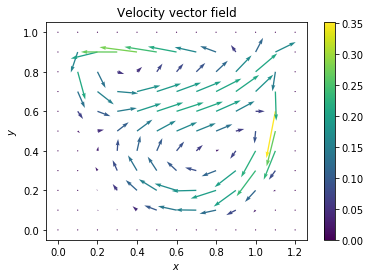

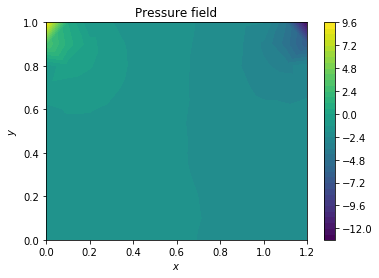

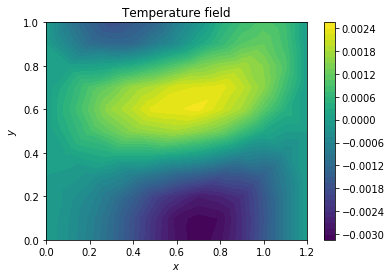

In [87]:
diff = fenics.Function(W)
diff.leaf_node().vector()[:] = w_h.leaf_node().vector()[:] - w_l.leaf_node().vector()[:]
plot_w(diff)

In [88]:
import pymor

In [89]:
pymor.__version__

'2020.2.2'

## Parameters
 
$T_i, Re, T_c, T_h, \kappa$

In [90]:
# ### pyMOR wrapping
from pymor.bindings.fenics import FenicsVectorSpace, FenicsOperator, FenicsVisualizer
from pymor.models.basic import StationaryModel
from pymor.operators.constructions import VectorOperator

In [91]:
space = FenicsVectorSpace(W)

In [92]:
from pymor.tools.formatsrc import print_source

In [93]:
from pymor.basic import *

In [133]:
op = FenicsOperator(F, space, space, w, boundary_conditions,
                    parameter_setter=lambda mu: Re.assign(mu['Re'].item()),
                    parameters={'Re':1},
                    #parameters={'T_i': 1,'T_c': 1,'T_h':1,'kappa':1,'Re':1},
                    solver_options={'inverse': 
                                    {'type': 'newton', 'rtol': 1e-6, 'maxiter':500,
                                    'error_measure': 'residual'}})

In [134]:
rhs = VectorOperator(op.range.zeros())

In [135]:
#w_0 = fenics.interpolate(fenics.Expression(("0.", "0.", "0.","T_i" ), 
#                         T_i = initial_temperature,element = mixed_element),W)

In [136]:
fom = StationaryModel(op, rhs,
                     visualizer=FenicsVisualizer(space))

In [137]:
def solve_fom_pymor(Re=1., rtol=1e-6, return_residuals=True):
    mu = fom.parameters.parse([Re])
    UU, data = newton(fom.operator, fom.rhs.as_vector(), 
                     mu=mu, rtol=rtol, return_residuals=return_residuals, 
                     error_measure='residual')
    # fom solution
    U_fe = fenics.Function(W)
    U_fe.leaf_node().vector()[:] = UU.to_numpy().squeeze()#.reshape((UU.to_numpy().size,))
    
    return U_fe

(n,1) -> (n,)

In [138]:
reynolds = 500.
U_py = solve_fom_pymor(Re=reynolds)
w = solve_fom_fenics(mu=reynolds)

01:54:51 newton:      norm:0.000e+00                                 res:5.523e+00
01:54:51 newton: it:1 norm:4.508e+01 upd:4.508e+01 rel_upd:1.000e+00 res:2.807e-02 red:5.083e-03 tot_red:5.083e-03
01:54:51 newton: it:2 norm:5.923e+01 upd:1.496e+01 rel_upd:2.526e-01 res:1.220e-02 red:4.345e-01 tot_red:2.208e-03
01:54:51 newton: it:3 norm:2.367e+01 upd:3.670e+01 rel_upd:1.551e+00 res:1.036e-02 red:8.498e-01 tot_red:1.877e-03
01:54:51 newton: it:4 norm:5.663e+01 upd:3.386e+01 rel_upd:5.980e-01 res:5.164e-03 red:4.983e-01 tot_red:9.351e-04
01:54:51 newton: it:5 norm:9.229e+01 upd:3.588e+01 rel_upd:3.888e-01 res:3.739e-03 red:7.240e-01 tot_red:6.770e-04
01:54:51 newton: it:6 norm:1.214e+01 upd:8.287e+01 rel_upd:6.825e+00 res:2.356e-04 red:6.300e-02 tot_red:4.265e-05
01:54:51 newton: it:7 norm:1.633e+01 upd:2.324e+01 rel_upd:1.423e+00 res:2.814e-06 red:1.194e-02 tot_red:5.095e-07
01:54:51 newton: Relative tolerance of 1e-06 for norm of residual reached. Converged.
         


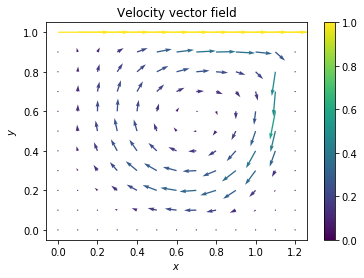

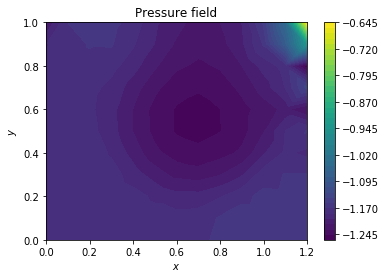

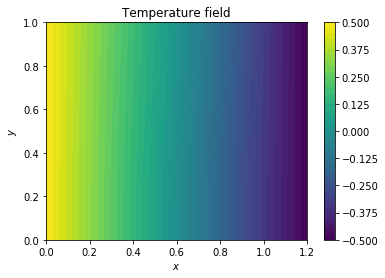

In [139]:
# fom solution
plot_w(U_py)

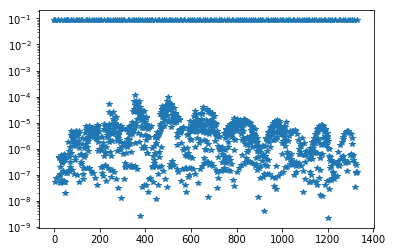

In [140]:
plt.semilogy(np.absolute( w.leaf_node().vector()[:]-U_py.leaf_node().vector()[:] ),'*')

In [141]:
np.linalg.norm( np.absolute( w.leaf_node().vector()[:]-U_py.leaf_node().vector()[:] ) )

1.0222880852017133

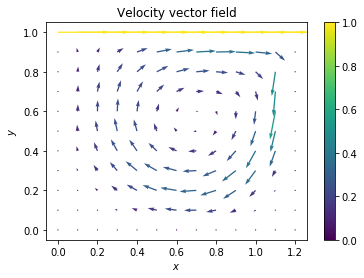

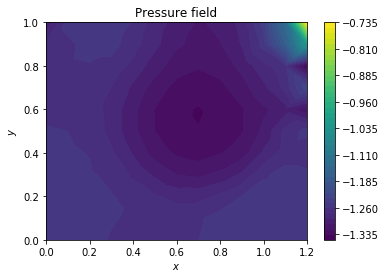

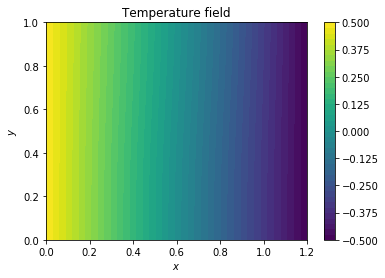

In [142]:
plot_w(w)

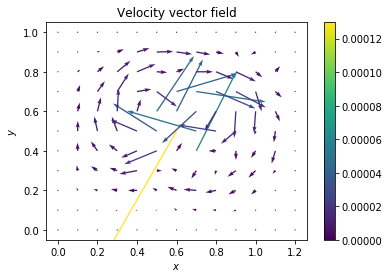

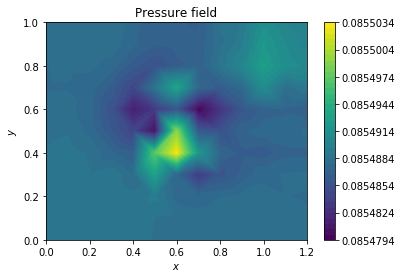

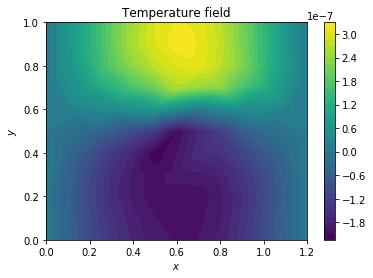

In [143]:
diff = fenics.Function(W)
diff.leaf_node().vector()[:] = U_py.leaf_node().vector()[:] - w.leaf_node().vector()[:]
plot_w(diff)

In [123]:
parameter_space = fom.parameters.space((1, 500.))

# ### ROM generation (POD/DEIM)
from pymor.algorithms.ei import ei_greedy
from pymor.algorithms.newton import newton
from pymor.algorithms.pod import pod
from pymor.operators.ei import EmpiricalInterpolatedOperator
from pymor.reductors.basic import StationaryRBReductor

U = fom.solution_space.empty()
#residuals = fom.solution_space.empty()

In [121]:
mu_list = (1000. - 1.) * np.random.rand(1,) + 1.

In [124]:
for mu_val in parameter_space.sample_randomly(10):#mu_list:
    #UU = fom.solve(mu)
    UU, data = newton(fom.operator, fom.rhs.as_vector(), 
                      mu=mu_val, #fom.parameters.parse([mu_val]), 
                      rtol=1e-6, return_residuals=True, 
                      maxiter=500,
                      error_measure='residual')
    U.append(UU)
    # U_fe = fenics.Function(W)
    # U_fe.leaf_node().vector()[:] = UU.to_numpy().reshape((UU.to_numpy().size,))
    # plot_w(U_fe)
    #residuals.append(data['residuals'])

01:49:44 newton:      norm:0.000e+00                                 res:5.523e+00
01:49:44 newton: it:1 norm:1.617e+03 upd:1.617e+03 rel_upd:1.000e+00 res:2.807e-02 red:5.083e-03 tot_red:5.083e-03
01:49:44 newton: it:2 norm:6.380e+02 upd:9.787e+02 rel_upd:1.534e+00 res:6.633e-05 red:2.363e-03 tot_red:1.201e-05
01:49:44 newton: it:3 norm:1.304e+03 upd:1.941e+03 rel_upd:1.489e+00 res:1.261e-10 red:1.901e-06 tot_red:2.283e-11
01:49:44 newton: Relative tolerance of 1e-06 for norm of residual reached. Converged.
         
01:49:44 newton:      norm:0.000e+00                                 res:5.523e+00
01:49:44 newton: it:1 norm:2.529e+01 upd:2.529e+01 rel_upd:1.000e+00 res:2.807e-02 red:5.083e-03 tot_red:5.083e-03
01:49:44 newton: it:2 norm:6.692e+01 upd:4.275e+01 rel_upd:6.388e-01 res:1.181e-02 red:4.209e-01 tot_red:2.139e-03
01:49:44 newton: it:3 norm:1.883e+02 upd:1.217e+02 rel_upd:6.461e-01 res:9.521e-03 red:8.059e-01 tot_red:1.724e-03
01:49:44 newton: it:4 norm:2.472e+02 upd:5.892e+

In [125]:
U.dim, len(U)

(1336, 10)

In [48]:
if 0:
    dofs, cb, _ = ei_greedy(residuals, rtol=1e-7)
    ei_op = EmpiricalInterpolatedOperator(fom.operator, collateral_basis=cb, 
                                      interpolation_dofs=dofs, triangular=True)
    rb, svals = pod(U, rtol=1e-7)
    fom_ei = fom.with_(operator=ei_op)
    reductor = StationaryRBReductor(fom_ei, rb)
    rom = reductor.reduce()
    # the reductor currently removes all solver_options so we need to add them again
    rom = rom.with_(operator=rom.operator.with_(solver_options=fom.operator.solver_options))

    # ### ROM validation
    import time
    import numpy as np

    # ensure that FFC is not called during runtime measurements
    rom.solve(1)

    errs = []
    speedups = []
    for mu in parameter_space.sample_randomly(10):
        tic = time.perf_counter()
        U = fom.solve(mu)
        t_fom = time.perf_counter() - tic

        tic = time.perf_counter()
        u_red = rom.solve(mu)
        t_rom = time.perf_counter() - tic

        U_red = reductor.reconstruct(u_red)
        errs.append(((U - U_red).norm() / U.norm())[0])
        speedups.append(t_fom / t_rom)
    print(f'Maximum relative ROM error: {max(errs)}')
    print(f'Median of ROM speedup: {np.median(speedups)}')
#

## Problems
- fix the pressure value
- use pod after

In [126]:
#rb, svals = pod(U, modes = 3, method='qr_svd')
if 1:
    dofs, cb, _ = ei_greedy(residuals, rtol=1e-7)
    ei_op = EmpiricalInterpolatedOperator(fom.operator, collateral_basis=cb, 
                                      interpolation_dofs=dofs, triangular=True)
    rb, svals = pod(U, rtol=1e-7)
    fom_ei = fom.with_(operator=ei_op)
    reductor = StationaryRBReductor(fom_ei, rb)
else:
    rb = gram_schmidt(U)
    reductor = StationaryRBReductor(fom, rb)

01:50:48 gram_schmidt: Orthonormalizing vector 1 again
01:50:48 gram_schmidt: Orthonormalizing vector 2 again
01:50:48 gram_schmidt: Orthonormalizing vector 3 again
01:50:48 gram_schmidt: Orthonormalizing vector 4 again
01:50:48 gram_schmidt: Orthonormalizing vector 5 again
01:50:48 gram_schmidt: Orthonormalizing vector 6 again
01:50:48 gram_schmidt: Orthonormalizing vector 7 again
01:50:48 gram_schmidt: Orthonormalizing vector 8 again
01:50:48 gram_schmidt: Orthonormalizing vector 9 again


In [144]:
rom = reductor.reduce()
# the reductor currently removes all solver_options so we need to add them again
rom = rom.with_(operator=rom.operator.with_(solver_options=fom.operator.solver_options))

In [146]:
rom.operator.solver_options

{'inverse': {'type': 'newton',
  'rtol': 1e-06,
  'maxiter': 500,
  'error_measure': 'residual'}}

In [147]:
# ensure that FFC is not called during runtime measurements
rom.solve(1)

01:55:43 |WARNING|FixedParameterOperator: Using inefficient generic projection operator
01:55:43 ProjectedOperator: Solving nonlinear problem using newton algorithm ...
01:55:43 |   newton:      norm:0.000e+00                                 res:4.146e+00
01:55:43 |   newton: it:1 norm:3.790e+06 upd:3.790e+06 rel_upd:1.000e+00 res:6.664e-03 red:1.607e-03 tot_red:1.607e-03
01:55:43 |   newton: it:2 norm:3.380e+06 upd:4.098e+05 rel_upd:1.212e-01 res:4.283e-08 red:6.428e-06 tot_red:1.033e-08
01:55:43 |   newton: Relative tolerance of 1e-06 for norm of residual reached. Converged.
         |   


NumpyVectorArray(
    [[ 3.37973571e+06 -2.90601371e+04  9.32977548e+03 -6.18482882e+02
      -3.58642370e+02  3.55834174e+02  4.22330891e-01 -6.07022883e-02
      -2.20632682e-02  6.01020605e-03]],
    NumpyVectorSpace(10))

In [130]:
import time

In [148]:
errs = []
speedups = []
for mu in parameter_space.sample_randomly(3):
    tic = time.perf_counter()
    U = fom.solve(mu)
    t_fom = time.perf_counter() - tic

    tic = time.perf_counter()
    u_red = rom.solve(mu)
    t_rom = time.perf_counter() - tic

    U_red = reductor.reconstruct(u_red)
    errs.append(((U - U_red).norm() / U.norm())[0])
    speedups.append(t_fom / t_rom)
print(f'Maximum relative ROM error: {max(errs)}')
print(f'Median of ROM speedup: {np.median(speedups)}')

01:55:48 StationaryModel: Solving StationaryModel for {Re: [100.63721729702151]} ...
01:55:48 FenicsOperator: Solving nonlinear problem using newton algorithm ...
01:55:48 |   newton:      norm:0.000e+00                                 res:5.523e+00
01:55:48 |   newton: it:1 norm:3.603e+02 upd:3.603e+02 rel_upd:1.000e+00 res:2.807e-02 red:5.083e-03 tot_red:5.083e-03
01:55:48 |   newton: it:2 norm:2.819e+02 upd:7.850e+01 rel_upd:2.785e-01 res:2.707e-03 red:9.643e-02 tot_red:4.902e-04
01:55:48 |   newton: it:3 norm:4.249e+02 upd:1.431e+02 rel_upd:3.367e-01 res:7.190e-05 red:2.656e-02 tot_red:1.302e-05
01:55:48 |   newton: it:4 norm:6.039e+02 upd:1.790e+02 rel_upd:2.964e-01 res:2.035e-08 red:2.831e-04 tot_red:3.686e-09
01:55:48 |   newton: Relative tolerance of 1e-06 for norm of residual reached. Converged.
         |   
01:55:48 |WARNING|FixedParameterOperator: Using inefficient generic projection operator
01:55:48 ProjectedOperator: Solving nonlinear problem using newton algorithm ...
0

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.60229e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:48 |   newton: it:15 norm:4.135e+09 upd:4.068e+08 rel_upd:9.840e-02 res:3.315e-03 red:9.937e-01 tot_red:7.996e-04
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=2.7271e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:48 |   newton: it:16 norm:3.587e+09 upd:5.476e+08 rel_upd:1.527e-01 res:3.255e-03 red:9.821e-01 tot_red:7.852e-04
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=4.31984e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:48 |   newton: it:17 norm:3.013e+09 upd:5.742e+08 rel_upd:1.906e-01 res:2.897e-03 red:8.898e-01 to

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=4.42897e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:49 |   newton: it:39 norm:1.715e+09 upd:1.099e+09 rel_upd:6.408e-01 res:3.216e-02 red:5.188e-01 tot_red:7.758e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=5.8951e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:49 |   newton: it:40 norm:1.273e+09 upd:4.416e+08 rel_upd:3.468e-01 res:3.072e-02 red:9.552e-01 tot_red:7.410e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.99149e-18): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:49 |   newton: it:41 norm:1.377e+09 upd:1.034e+08 rel_upd:7.513e-02 res:2.789e-02 red:9.077e-01 to

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.77954e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:49 |   newton: it:63 norm:2.268e+09 upd:8.259e+07 rel_upd:3.641e-02 res:1.484e-02 red:9.712e-01 tot_red:3.580e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=3.7239e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:49 |   newton: it:64 norm:2.301e+09 upd:3.256e+07 rel_upd:1.415e-02 res:1.482e-02 red:9.988e-01 tot_red:3.576e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.87716e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:49 |   newton: it:65 norm:2.287e+09 upd:1.383e+07 rel_upd:6.049e-03 res:1.481e-02 red:9.990e-01 to

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=5.22025e-19): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:49 |   newton: it:87 norm:4.868e+09 upd:3.037e+09 rel_upd:6.238e-01 res:1.437e+00 red:2.519e-01 tot_red:3.466e-01
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.4282e-19): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:49 |   newton: it:88 norm:4.877e+09 upd:8.771e+06 rel_upd:1.798e-03 res:3.751e-01 red:2.610e-01 tot_red:9.047e-02
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=2.37321e-19): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:49 |   newton: it:89 norm:1.013e+10 upd:5.252e+09 rel_upd:5.185e-01 res:3.127e-01 red:8.337e-01 to

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=2.82149e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:50 |   newton: it:112 norm:2.247e+09 upd:3.950e+08 rel_upd:1.758e-01 res:1.370e-03 red:9.594e-01 tot_red:3.303e-04
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=2.76828e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:50 |   newton: it:113 norm:2.498e+09 upd:2.512e+08 rel_upd:1.006e-01 res:1.286e-03 red:9.387e-01 tot_red:3.101e-04
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=3.35008e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:50 |   newton: it:114 norm:2.262e+09 upd:2.354e+08 rel_upd:1.041e-01 res:1.211e-03 red:9.418e-0

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=3.6448e-19): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:50 |   newton: it:136 norm:2.738e+09 upd:1.185e+08 rel_upd:4.328e-02 res:1.939e-02 red:8.804e-01 tot_red:4.677e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.28366e-19): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:50 |   newton: it:137 norm:2.683e+09 upd:5.525e+07 rel_upd:2.060e-02 res:1.677e-02 red:8.647e-01 tot_red:4.044e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=2.95697e-19): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:50 |   newton: it:138 norm:2.485e+09 upd:1.980e+08 rel_upd:7.969e-02 res:1.673e-02 red:9.980e-01

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.45061e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:50 |   newton: it:161 norm:1.186e+09 upd:6.014e+07 rel_upd:5.071e-02 res:6.287e-03 red:9.953e-01 tot_red:1.517e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.41389e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:50 |   newton: it:162 norm:1.128e+09 upd:5.852e+07 rel_upd:5.190e-02 res:6.265e-03 red:9.966e-01 tot_red:1.511e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.71354e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:50 |   newton: it:163 norm:1.179e+09 upd:5.113e+07 rel_upd:4.338e-02 res:6.188e-03 red:9.876e-0

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=4.95175e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:50 |   newton: it:185 norm:2.330e+09 upd:1.272e+09 rel_upd:5.458e-01 res:1.912e-02 red:3.545e-01 tot_red:4.613e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=8.96211e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:50 |   newton: it:186 norm:2.011e+09 upd:3.194e+08 rel_upd:1.588e-01 res:1.715e-02 red:8.967e-01 tot_red:4.136e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=5.44639e-21): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:50 |   newton: it:187 norm:2.228e+09 upd:2.170e+08 rel_upd:9.739e-02 res:1.708e-02 red:9.960e-0

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=3.1195e-21): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:51 |   newton: it:209 norm:2.623e+09 upd:3.016e+08 rel_upd:1.150e-01 res:1.531e-02 red:9.948e-01 tot_red:3.692e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=2.52013e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:51 |   newton: it:210 norm:3.308e+09 upd:6.846e+08 rel_upd:2.070e-01 res:1.278e-02 red:8.351e-01 tot_red:3.083e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=2.13862e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:51 |   newton: it:211 norm:2.283e+09 upd:1.025e+09 rel_upd:4.488e-01 res:1.125e-02 red:8.799e-01

01:55:51 |   newton: it:232 norm:2.796e+09 upd:6.739e+09 rel_upd:2.410e+00 res:1.390e+02 red:2.948e+03 tot_red:3.354e+01
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.46677e-18): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:51 |   newton: it:233 norm:3.797e+08 upd:3.176e+09 rel_upd:8.365e+00 res:3.477e+01 red:2.501e-01 tot_red:8.387e+00
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=9.60718e-19): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:51 |   newton: it:234 norm:1.959e+09 upd:1.579e+09 rel_upd:8.062e-01 res:8.698e+00 red:2.501e-01 tot_red:2.098e+00
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=6.01567e-19): result may not be accurate.
  R = solve(self.matrix

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=6.56438e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:51 |   newton: it:257 norm:3.589e+09 upd:2.704e+09 rel_upd:7.534e-01 res:2.454e-01 red:9.213e-01 tot_red:5.920e-02
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=4.70029e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:51 |   newton: it:258 norm:4.002e+09 upd:4.131e+08 rel_upd:1.032e-01 res:2.392e-01 red:9.748e-01 tot_red:5.771e-02
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=5.45729e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:51 |   newton: it:259 norm:1.126e+10 upd:7.256e+09 rel_upd:6.445e-01 res:2.165e-01 red:9.051e-0

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=8.43478e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:52 |   newton: it:282 norm:4.430e+08 upd:8.279e+07 rel_upd:1.869e-01 res:1.067e-02 red:9.848e-01 tot_red:2.574e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.55727e-19): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:52 |   newton: it:283 norm:2.470e+08 upd:6.901e+08 rel_upd:2.793e+00 res:9.624e-03 red:9.019e-01 tot_red:2.321e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=2.59216e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:52 |   newton: it:284 norm:3.233e+08 upd:7.630e+07 rel_upd:2.360e-01 res:9.490e-03 red:9.861e-0

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.41521e-18): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:52 |   newton: it:306 norm:6.254e+10 upd:6.576e+10 rel_upd:1.051e+00 res:8.408e+01 red:2.513e-01 tot_red:2.028e+01
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=4.88028e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:52 |   newton: it:307 norm:7.633e+10 upd:1.379e+10 rel_upd:1.806e-01 res:6.786e+01 red:8.071e-01 tot_red:1.637e+01
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=4.04772e-19): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:52 |   newton: it:308 norm:4.296e+10 upd:3.336e+10 rel_upd:7.765e-01 res:1.664e+01 red:2.452e-0

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.34709e-19): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:52 |   newton: it:330 norm:3.508e+08 upd:2.888e+08 rel_upd:8.234e-01 res:1.582e-01 red:9.516e-01 tot_red:3.816e-02
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.30478e-19): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:52 |   newton: it:331 norm:1.103e+09 upd:1.453e+09 rel_upd:1.318e+00 res:1.464e-01 red:9.258e-01 tot_red:3.532e-02
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=7.6254e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:52 |   newton: it:332 norm:3.487e+08 upd:7.540e+08 rel_upd:2.162e+00 res:1.359e-01 red:9.278e-01

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=2.21282e-19): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:52 |   newton: it:354 norm:2.541e+11 upd:2.432e+11 rel_upd:9.574e-01 res:5.091e+02 red:2.500e-01 tot_red:1.228e+02
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=4.31978e-19): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:52 |   newton: it:355 norm:1.236e+11 upd:1.305e+11 rel_upd:1.056e+00 res:1.273e+02 red:2.501e-01 tot_red:3.072e+01
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=6.04661e-19): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:52 |   newton: it:356 norm:6.120e+10 upd:6.237e+10 rel_upd:1.019e+00 res:3.185e+01 red:2.501e-0

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.79525e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:53 |   newton: it:379 norm:1.095e+09 upd:4.974e+08 rel_upd:4.540e-01 res:6.994e-03 red:5.915e-01 tot_red:1.687e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=3.53492e-21): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:53 |   newton: it:380 norm:5.183e+08 upd:5.772e+08 rel_upd:1.114e+00 res:4.515e-03 red:6.456e-01 tot_red:1.089e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=7.05417e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:53 |   newton: it:381 norm:4.634e+08 upd:5.488e+07 rel_upd:1.184e-01 res:4.453e-03 red:9.861e-0

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.14303e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:53 |   newton: it:403 norm:4.200e+09 upd:4.519e+08 rel_upd:1.076e-01 res:2.496e-01 red:9.956e-01 tot_red:6.021e-02
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=4.09889e-21): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:53 |   newton: it:404 norm:4.261e+09 upd:6.050e+07 rel_upd:1.420e-02 res:2.495e-01 red:9.995e-01 tot_red:6.018e-02
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=2.06632e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:53 |   newton: it:405 norm:4.688e+09 upd:4.276e+08 rel_upd:9.121e-02 res:2.486e-01 red:9.966e-0

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.12049e-19): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:53 |   newton: it:427 norm:1.120e+10 upd:2.558e+10 rel_upd:2.284e+00 res:3.776e+00 red:2.583e-01 tot_red:9.108e-01
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=7.65071e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:53 |   newton: it:428 norm:7.761e+09 upd:3.439e+09 rel_upd:4.430e-01 res:9.826e-01 red:2.602e-01 tot_red:2.370e-01
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.7817e-19): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:53 |   newton: it:429 norm:1.331e+09 upd:6.430e+09 rel_upd:4.829e+00 res:2.102e-01 red:2.139e-01

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=7.87687e-21): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:54 |   newton: it:452 norm:1.266e+09 upd:1.570e+07 rel_upd:1.240e-02 res:6.992e-03 red:9.981e-01 tot_red:1.687e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.21377e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:54 |   newton: it:453 norm:1.224e+09 upd:4.147e+07 rel_upd:3.387e-02 res:6.987e-03 red:9.993e-01 tot_red:1.685e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.94757e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:54 |   newton: it:454 norm:1.273e+09 upd:4.857e+07 rel_upd:3.816e-02 res:6.884e-03 red:9.852e-0

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=2.16417e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:54 |   newton: it:477 norm:3.897e+08 upd:9.241e+07 rel_upd:2.372e-01 res:2.123e-04 red:8.987e-01 tot_red:5.120e-05
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=2.20516e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:54 |   newton: it:478 norm:3.316e+08 upd:5.805e+07 rel_upd:1.751e-01 res:1.993e-04 red:9.391e-01 tot_red:4.808e-05
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.07825e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:54 |   newton: it:479 norm:3.829e+08 upd:5.127e+07 rel_upd:1.339e-01 res:1.976e-04 red:9.915e-0

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.21549e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:54 |   newton: it:4 norm:7.268e+08 upd:4.677e+08 rel_upd:6.436e-01 res:6.409e-04 red:1.686e-01 tot_red:1.546e-04
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=2.85867e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:54 |   newton: it:5 norm:4.551e+08 upd:2.718e+08 rel_upd:5.972e-01 res:6.388e-04 red:9.968e-01 tot_red:1.541e-04
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.5057e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:54 |   newton: it:6 norm:2.820e+08 upd:1.730e+08 rel_upd:6.136e-01 res:6.059e-04 red:9.485e-01 tot_r

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.69186e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:55 |   newton: it:28 norm:7.800e+08 upd:5.844e+07 rel_upd:7.493e-02 res:9.045e-03 red:8.562e-01 tot_red:2.182e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.72761e-21): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:55 |   newton: it:29 norm:8.567e+08 upd:7.666e+07 rel_upd:8.949e-02 res:9.016e-03 red:9.968e-01 tot_red:2.175e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=5.57185e-21): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:55 |   newton: it:30 norm:1.196e+09 upd:3.396e+08 rel_upd:2.839e-01 res:8.718e-03 red:9.670e-01 t

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=5.12412e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:55 |   newton: it:52 norm:1.711e+08 upd:1.483e+08 rel_upd:8.666e-01 res:4.123e-03 red:1.987e-01 tot_red:9.945e-04
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=2.60251e-20): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:55 |   newton: it:53 norm:3.274e+07 upd:1.383e+08 rel_upd:4.225e+00 res:3.578e-04 red:8.678e-02 tot_red:8.630e-05
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=7.49321e-21): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:55:55 |   newton: it:54 norm:1.486e+08 upd:1.159e+08 rel_upd:7.797e-01 res:5.069e-05 red:1.417e-01 t

Maximum relative ROM error: 92168.19438051872
Median of ROM speedup: 0.09420020721542138


In [150]:
def solve_rom_pymor(Re=1., rtol=1e-6, return_residuals=True):
    mu = rom.parameters.parse([Re])
    u_red = rom.solve(mu) 
    U_red = reductor.reconstruct(u_red)
    # fom solution
    U_fe = fenics.Function(W)
    U_fe.leaf_node().vector()[:] = U_red.to_numpy().squeeze()#.reshape((UU.to_numpy().size,))
    
    return U_fe

In [151]:
reynolds = 50.
U_py = solve_rom_pymor(Re=reynolds)
w = solve_fom_fenics(mu=reynolds)

01:59:40 |WARNING|FixedParameterOperator: Using inefficient generic projection operator
01:59:40 ProjectedOperator: Solving nonlinear problem using newton algorithm ...
01:59:40 |   newton:      norm:0.000e+00                                 res:4.146e+00
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.1755e-19): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:59:41 |   newton: it:1 norm:1.730e+06 upd:1.730e+06 rel_upd:1.000e+00 res:6.644e-03 red:1.603e-03 tot_red:1.603e-03
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/operators/numpy.py:328: LinAlgWarning: Ill-conditioned matrix (rcond=1.00234e-19): result may not be accurate.
  R = solve(self.matrix, V.to_numpy().T).T
01:59:41 |   newton: it:2 norm:1.599e+06 upd:3.329e+06 rel_upd:2.082e+00 res:1.173e-04 red:1.766e-02 tot_red:2.830e-05
/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/oper

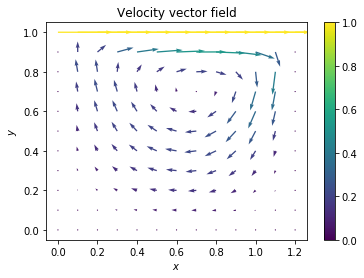

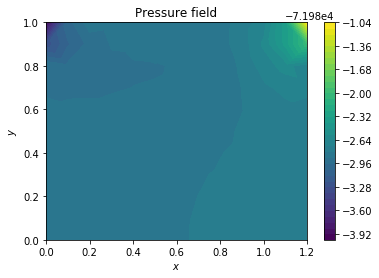

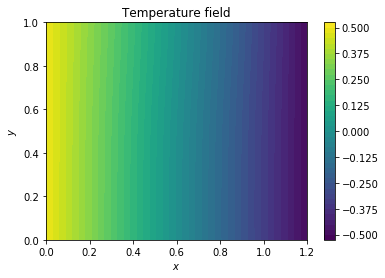

In [152]:
plot_w(U_py)

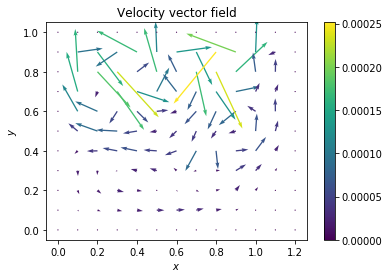

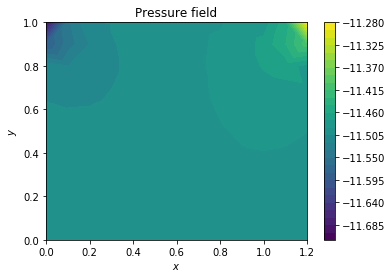

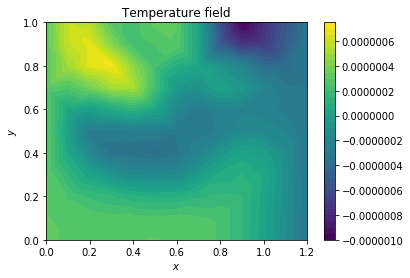

In [153]:
diff = fenics.Function(W)
diff.leaf_node().vector()[:] = U_py.leaf_node().vector()[:] - w.leaf_node().vector()[:]
plot_w(diff)